# TAL aplicado al análisis del discurso de los medios de prensa 📰🤓🔥


Random forest es un algoritmo de aprendizaje supervisado. Se puede utilizar tanto para clasificación como para regresión. También es el algoritmo más flexible y fácil de usar. Random forest está compuesto por árboles. Se dice que cuantos más árboles tiene, más robusto es un bosque. Random forest crea árboles de decisión sobre muestras de datos seleccionadas al azar, obtienen predicciones de cada árbol y seleccionan la mejor solución mediante votación. También proporciona un indicador bastante bueno de la importancia de la función.



### índex

1. [Importación del dataset](a)
2. [Preprocesamiento y representación vectorial](b)
3. [Entrenamiento del modelo de clasificación](b)
4. [Evaluación del modelo de clasificación](c)

    4.4 [Matriz de confusión](d)


In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
#NLP
import spacy
nlp = spacy.load("es_core_news_sm")
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
import string

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression # Regresion Logística

# Data manipulation
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from tqdm import tqdm


### 1. Importación del dataset


In [3]:
df = pd.read_csv("topics.csv",sep=',',error_bad_lines=False)
df.drop(['Unnamed: 0'], axis = 1, inplace=True) # Para suprimir la columna ID
df.drop(columns=['text','media_outlet', 'url','topic'], inplace=True)

df = df.astype({"label": str})
df.replace("0.0","mundo", inplace=True)
df.replace("1.0","economia", inplace=True)
df.replace("2.0","politica", inplace=True)
df.replace("3.0","ciencia", inplace=True)
df.replace("6.0","deporte", inplace=True)
df.replace("8.0","crimen", inplace=True)
df.replace("9.0","salud", inplace=True)
dfc = df[df['label']!="5.0"]
dfc = dfc[dfc['label']!="7.0"]
df

/home/rickiwasho/miniconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,content,label
0,Edificio se inunda tras rotura de piscina en C...,politica
1,"Trump visita Kenosha y califica de ""terrorismo...",ciencia
2,El secreto detalle en la vestimenta de Pablo E...,ciencia
3,Extraño tiburón sin piel es avistado nadando e...,ciencia
4,"""Melania y yo"": La exmejor mejor amiga revela ...",ciencia
...,...,...
69308,"Paris destaca caída ""moderada"" de casos, pero ...",salud
69309,Diputado Ilabaca (PS) critica al Gobierno por ...,politica
69310,Provoste se distancia de anuncio del President...,politica
69311,"Vacunas CanSino, que requieren una sola dosis,...",salud


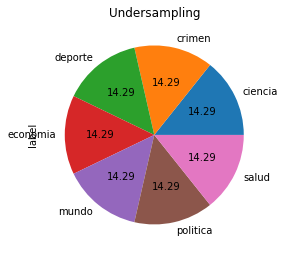

In [4]:
undersample = RandomUnderSampler(random_state=0)
x_res,y_res = undersample.fit_resample(dfc,dfc['label'])
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Undersampling")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_res['content'],y_res, test_size=0.5)

### 2. Preprocesamiento y representación vectorial

In [6]:
# Create our list of punctuation marks
punctuations = [".",",","!","?", "#","&"]

# Create our list of stopwords
stop_words=[""]

# Load English tokenizer, tagger, parser, NER and word vectors
parser = Spanish()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lower_ for word in mytokens]
        
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [7]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow_vector

CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f01efa40700>)

In [8]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

### 3. Entrenamiento del modelo de clasificación

In [9]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(random_state=0)

model3 = Pipeline([('preprocessing', bow_vector),
                 ('regression-ML', modelRF)])

# model generation
model3.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f01efa40700>)),
                ('regression-ML', RandomForestClassifier(random_state=0))])


### 4. Evaluación del modelo de clasificación


In [10]:
# Predicting with a test dataset
predicted = model3.predict(X_test)
print(predicted)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, 
                                           average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, 
                                           average='micro'))

['salud' 'salud' 'salud' ... 'crimen' 'crimen' 'salud']
Logistic Regression Accuracy: 0.6265899049404204
Logistic Regression Precision: 0.6265899049404204
Logistic Regression Recall: 0.6265899049404204



### 4.1. Matriz de confusión


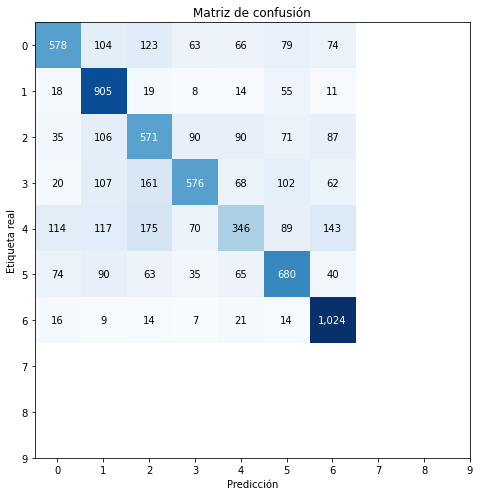

              precision    recall  f1-score   support

     ciencia      0.676     0.532     0.595      1087
      crimen      0.629     0.879     0.733      1030
     deporte      0.507     0.544     0.525      1050
    economia      0.678     0.526     0.592      1096
       mundo      0.516     0.328     0.401      1054
    politica      0.624     0.649     0.636      1047
       salud      0.711     0.927     0.804      1105

    accuracy                          0.627      7469
   macro avg      0.620     0.626     0.613      7469
weighted avg      0.621     0.627     0.613      7469



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(14, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')
    plt.show()

cm = confusion_matrix(y_true=y_test, y_pred=predicted)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])
print(classification_report(y_test, predicted, digits=3))